<p style="font-size:32pt;">LAMA Task No. 4: PCA and Clustering </p>
<p style="font-size:32pt;">with Samsung Human Activity Recognition Dataset</p>

In this part of the task, we will work with the [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. The dataset should reside in the folder "HAR_dataset". The data comes from accelerometers and gyros of Samsung Galaxy S3 mobile phones (you can find more info about the features using the link above). The type of activity of a person with a phone in his/her pocket is also known – whether he/she walked, stood, lay, sat or walked up or down the stairs.

First, we pretend that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then, we solve the problem of determining the type of physical activity as a classification problem.

# Preparation

We import the necessary libraries Pandas, Seaborn, Numpy. From scikit-learn, import the metrics, KMeans, PCA, GridSearchCV, StandardScaler and some other necessary imports and definitions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
%matplotlib inline
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

#Define a fixed random state
RANDOM_STATE = 17

## Import your dataset

Let's proceed with importing our dataset. Load both the training and test data as well as the corresponding labels. Tip: Numpy has a function to load text files. Load the labels as integer type.

In [3]:
### STUDENT CODE HERE

X_test = np.genfromtxt('HAR_dataset\X_test.txt', dtype=None, missing_values='NaN')
X_train = np.genfromtxt('HAR_dataset\X_train.txt', dtype=None, missing_values='NaN')
y_test = np.genfromtxt('HAR_dataset\y_test.txt', dtype=int, missing_values='NaN')
y_train = np.genfromtxt('HAR_dataset\y_train.txt', dtype=int, missing_values='NaN')

### STUDENT CODE until HERE

Check if the dimensions of the dataset are correct.

In [4]:
# Checking dimensions
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

## Data Understanding

Now after we loaded the data, we want to get a quick understanding of our dataset. 

**Question:** How many observations and features do we have? How many of the features are numeric? Do we have missing values?

**Answer:** We have 7352 observations in the training data and 2947 observations in the test data. Both datasets have 561 features. All features are numeric. There are no missing values.


In [12]:
### STUDENT CODE HERE

print(X_test.dtype)
print(X_train.dtype)
print(np.isnan(X_test).sum())
print(np.isnan(X_train).sum())
print(np.isnan(y_test).sum())
print(np.isnan(y_train).sum())

### STUDENT CODE until HERE

float64
float64
0
0
0
0


Now we load the feature names of the file "features.txt". For clustering, we do not need a target vector, so in the beginning we'll work with the combination of training and test samples. The following code merges `X_train` with `X_test`, and `y_train` with `y_test`. Afterwards the merged data `X_train` with `X_test` is put in one dataframe with the specified feature names. 

In [13]:
featureNames = np.loadtxt("HAR_dataset/features.txt",dtype=str)
X = pd.DataFrame(data = np.vstack((X_train,X_test)),columns=featureNames)
y = pd.Series(data = np.concatenate((y_train,y_test)),name='label')

In [14]:
# Checking dimensions
assert(X.shape == (7352+2947, 561))
assert(y.shape == (7352+2947, ))


Use a method you learned before to get a summary of the numeric values. 

**Question:** What can we see from that summary? Especially, have a look on scaling or centering.

**Answer:** All values are between -1 and 1. The data is normalized but not mean-centered.


In [15]:
### STUDENT CODE HERE

X.describe()

### STUDENT CODE until HERE

,"(1, tBodyAcc-mean()-X)","(2, tBodyAcc-mean()-Y)","(3, tBodyAcc-mean()-Z)","(4, tBodyAcc-std()-X)","(5, tBodyAcc-std()-Y)","(6, tBodyAcc-std()-Z)","(7, tBodyAcc-mad()-X)","(8, tBodyAcc-mad()-Y)","(9, tBodyAcc-mad()-Z)","(10, tBodyAcc-max()-X)",...,"(552, fBodyBodyGyroJerkMag-meanFreq())","(553, fBodyBodyGyroJerkMag-skewness())","(554, fBodyBodyGyroJerkMag-kurtosis())","(555, angle(tBodyAccMean,gravity))","(556, angle(tBodyAccJerkMean),gravityMean))","(557, angle(tBodyGyroMean,gravityMean))","(558, angle(tBodyGyroJerkMean,gravityMean))","(559, angle(X,gravityMean))","(560, angle(Y,gravityMean))","(561, angle(Z,gravityMean))"
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,0.126708,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.245443,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.019481,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,0.136245,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,0.288960,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Visualization and Reduction with PCA

As we have seen, the dataset contains more than 500 columns (features). It is not possible to show all of the data. We won't be able to see or recognize anything, if we try to plot a distribution or histograms of all features. Besides that, we also don't know which columns may be interesting. But, what luck we learned a method to visualize datasets with such a high dimension: PCA!

**Question**: What type of scaling do we have to perform to fulfill the requirements of PCA? Perform the necessary step.

**Answer:** The dataset has to be mean-centered.


In [16]:
### STUDENT CODE HERE

X_centered = X - X.mean()

### STUDENT CODE until HERE


Now copy the function to plot the accumulated variance of the principal components you wrote in the beginning of the task. Modify the plotting function such that only 100 features are displayed.

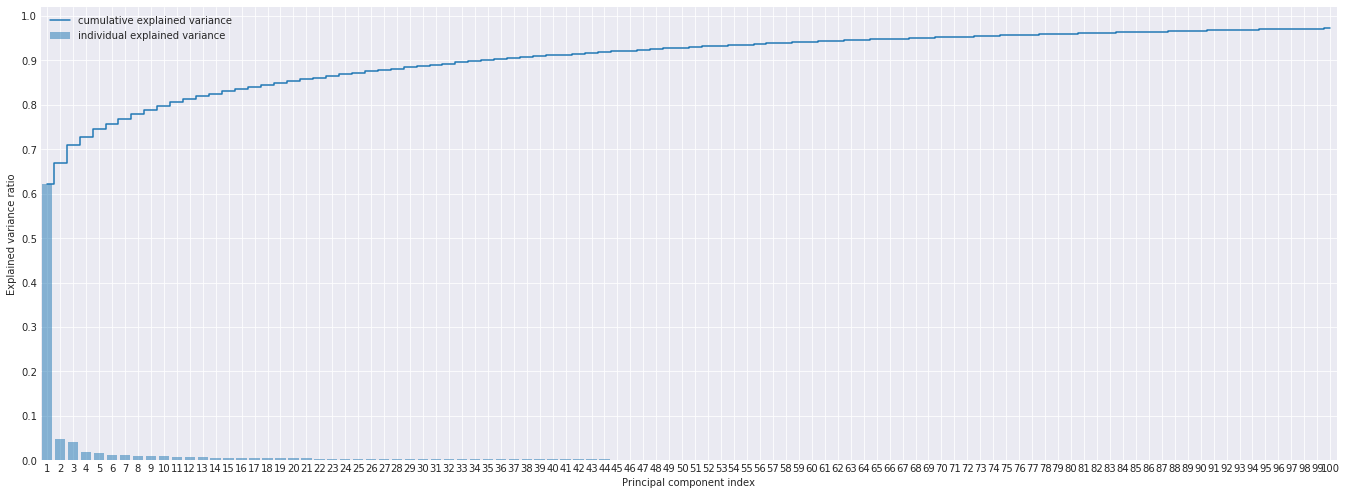

In [123]:
### STUDENT CODE HERE

def plotPCAVariance(var_exp, X):
    #STUDENT CODE HERE
    
    cum_var_exp = [sum(var_exp[:(i+1)]) for i in range(len(var_exp))]
    
    #STUDENT CODE until HERE
    
    #plotting individual explained variance is given
    fig = plt.figure(figsize=(20,7))
    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
    ax.bar(range(1, 100+1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index')    
    ax.set_xlim(0.5, 100+0.5)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(np.arange(1,100+1,1))

    #plotting
    ax.step(range(1, 100+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
    ax.legend(loc='best')
    return fig, ax

#  fit to centered data with k=Number of Features
pca = PCA(n_components=100).fit(X_centered)
# get explained variance
var_exp = pca.explained_variance_ratio_
#plot
fig, ax = plotPCAVariance(var_exp, X_centered)

### STUDENT CODE until HERE

Use the sklearn-PCA to calculate the transformation with all the variables. At first we don't specify a number of components we want to retain or a ratio of explained variance. Plot the variance using your function from above.

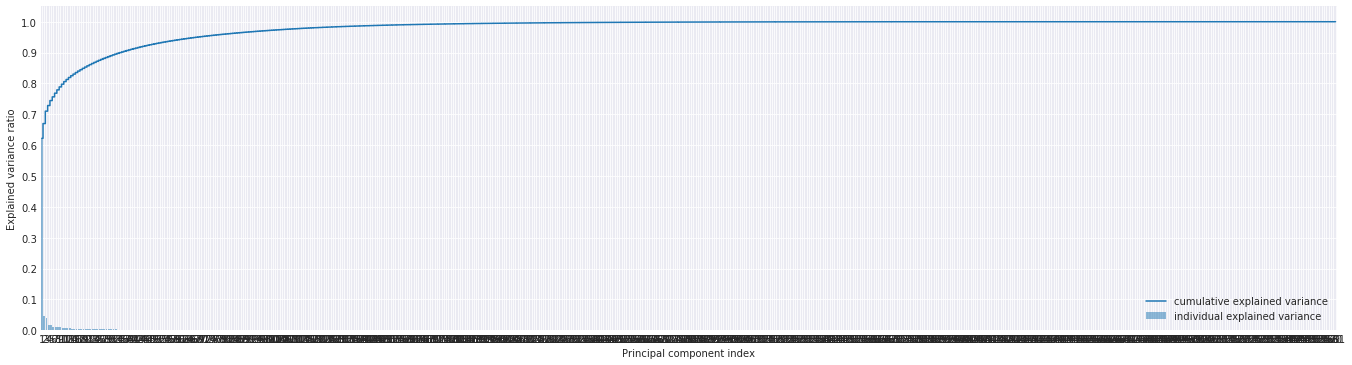

In [25]:
### STUDENT CODE HERE
def plotPCAVariance(var_exp, X):
    
    cum_var_exp = [sum(var_exp[0:i+1]) for i in range(len(var_exp))]
    
    #plotting individual explained variance is given
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
    ax.bar(range(1, X.shape[1]+1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index')    
    ax.set_xlim(0.5, X.shape[1]+0.5)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(np.arange(1,X.shape[1]+1,1))

    # plotting
    ax.step(range(1, X.shape[1]+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
    ax.legend(loc='best')
    return fig, ax

pca = PCA().fit(X_centered)
var_exp = pca.explained_variance_ratio_
fig, ax = plotPCAVariance(var_exp, X_centered)
### STUDENT CODE until HERE

**Task:** Now, reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the data. Use the scaled dataset and set a fixed `random_state` (use the RANDOM_STATE constant).

In [41]:
### STUDENT CODE HERE

pca = PCA(n_components=0.9 ,svd_solver='full', random_state=RANDOM_STATE)
pca.fit(X_centered)
var_exp = pca.explained_variance_ratio_
print(len(var_exp))

#total explained variance
cum_var_exp = sum(var_exp) 
print(cum_var_exp)

### STUDENT CODE until HERE

36
0.9021695884208629


**Question: What is the minimum number of principal components required to cover the 90% of the variance of the data?**

**Answer:**  The minimum number of principal component required to cover at least 90% is 36.


**Question: What percentage of the variance is covered by the first principal component? Round to the nearest percent.**

**Answer:** The first principal component covers 62% of the variance.


In [124]:
### STUDENT CODE HERE

pca = PCA(n_components=1, random_state=RANDOM_STATE)
pca.fit(X_centered)
var_exp = pca.explained_variance_ratio_
print("%.0f %%"%(var_exp[0]*100))

### STUDENT CODE until HERE

62 %


**Task:** Visualize the data in projection on the first two principal components.

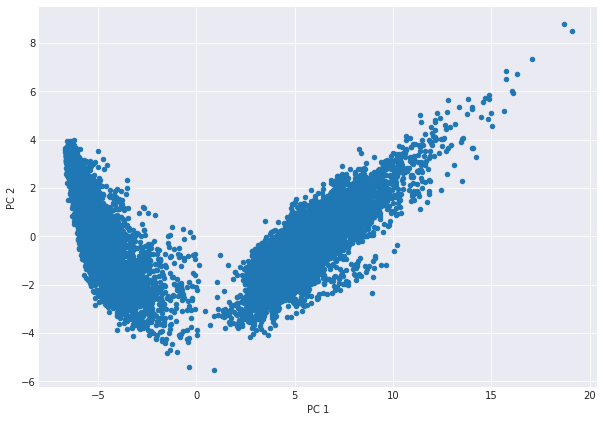

In [56]:
### STUDENT CODE HERE 

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_centered)

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### STUDENT CODE until HERE

**Question:** Describe the plot results. What can we conclude looking at the results? What is the benefit of PCA?

**Answer:** The data has a lot of variance on the chosen axes.  The benefit of PCA is that we can keep a lot of variance in our data without having to work with unnecessary details.


# Clustering
Perform clustering with the `KMeans` method, training the model on data with reduced dimensionality (by PCA).  As a first try, we will look for the number of clusters we see with naked eye. In general case we will not know how many clusters we should be looking for.

Parameters of the K-Means Algorithm:

- ** n_clusters ** = as noted above
- ** n_init ** = 100
- ** random_state ** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

In [58]:
### STUDENT CODE HERE

kmeans = KMeans(n_clusters=2, n_init=100, random_state= RANDOM_STATE ,init='k-means++').fit(X_pca)

labels_pred = kmeans.predict(X_pca)

### STUDENT CODE until HERE

Visualize your results using the predicted cluster labels as the color of your plot.

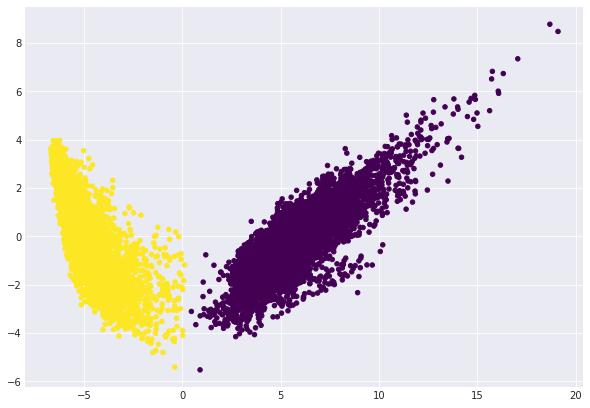

In [59]:
### STUDENT CODE HERE

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred, s=20, cmap='viridis');
plt.show()

### STUDENT CODE until HERE

**Question:**
What is your interpretation of the clustering result? Describe the plot.

**Answer:** Just by looking at the previous plot, I would have clustered the data in the same way.


## Varying the number of clusters

Our first estimate of the number of clusters led to a nice result. But what if we could get more information out of the dataset if we vary the number of clusters?

### Elbow Method
We want to use the elbow method we learned before to estimate the number of clusters. Therefore, fill in the following code. 

In [125]:
def calculate_k_loss(X, k_min, k_max):
    ### STUDENT CODE HERE

    k_values = np.arange(k_min, k_max+1)
    losses = []
    
    for k in k_values:
        kmeans = KMeans(n_clusters= k, random_state=RANDOM_STATE).fit(X)
        labels_pred = kmeans.predict(X)
        losses.append(kmeans.inertia_)
    
    ### STUDENT CODE until HERE
    
    return k_values, losses


Use the code below to call your function and plot the loss versus the k-values. Use a range of one to ten for the value of k.

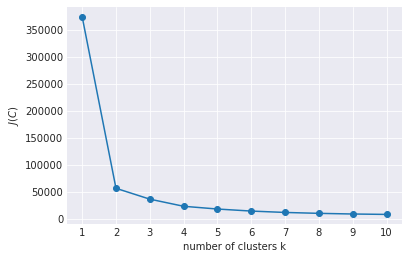

In [127]:
# call your function
### STUDENT CODE HERE

k_values, losses = calculate_k_loss(X_pca, 1, 10)

### STUDENT CODE until HERE
# Plot k_values vs inertias
plt.plot(k_values, losses, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('$ J(C)$')
plt.xticks(k_values)
plt.show()

**Question:** How many clusters can we choose according to the elbow method?

**Answer:** Since the elbow method tries to minimize the loss, we would have to chose ten clusters.


### Silhouette Score

Let's use the silhouette score to get a value for $k$. Import the necessary library and fill in the code below. Get the score for values of $k$ between $2$ and $10$.

In [71]:
from sklearn.metrics import silhouette_score

def calculate_k_silhouette(X, k_min, k_max):
    ### STUDENT CODE HERE
    
    ks = np.arange(k_min, k_max+1)
    silhouettes = []
    
    for k in ks:
        kmeans = KMeans(n_clusters= k, random_state=RANDOM_STATE).fit(X)
        labels_pred = kmeans.predict(X)
        silhouettes.append(silhouette_score(X,labels_pred))

    ### STUDENT CODE until HERE
    
    return ks, silhouettes


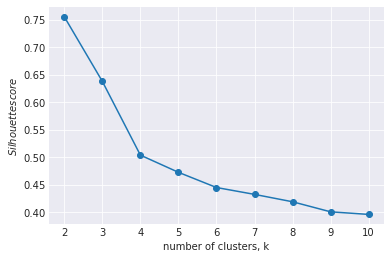

In [73]:
### STUDENT CODE HERE

ks, silhouettes = calculate_k_silhouette(X_pca, 2, 10)

### STUDENT CODE until HERE
# Plot ks vs inertias
plt.plot(ks, silhouettes, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('$ Silhouette score $')
plt.xticks(ks)
plt.show()

**Question:** What is your conclusion looking at the results of the two metrics? What value would you choose for $k$?

**Answer:** The silhouette score should be maximized, thererfore k should be two which however contradicts our findings when evaluting using the elbow method. However the results of the elbow methods don't improve that much for k greater than two and the results of the silhouette score get significantly worse for k greater than two. Which is why we would chose the value two for k.


## Analyzing the given Label Information

### Class Distribution
Let's find out how many classes there are actually given in the dataset. Calculate the number of unique values of the labels of the target class. How many data points do we have in each class? Plot a histogram for the distribution of class labels.

In [74]:
### STUDENT CODE HERE

y.value_counts()

### STUDENT CODE until HERE



6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: label, dtype: int64

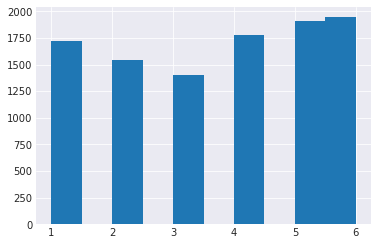

In [76]:
#plotting the histogram
### STUDENT CODE HERE

plt.hist(y);

### STUDENT CODE until HERE

**Question: [Have a look at the dataset description.](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names) What is the meaning of the class labels?**

**Answer:**

* 1 = walking
* 2 = walking upstairs
* 3 = walking downstairs
* 4 = sitting
* 5 = standing
* 6 = laying


### Showing class distribution with PCA data

To get a better impression of the real classes in the dataset, we want to show the labels of the data points in our PCA transformed dataset. Make a scatter plot of the PCA transformed data and mark the classes in different colors.

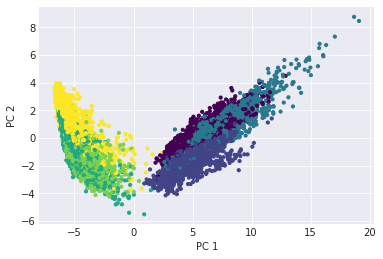

In [78]:
### STUDENT CODE HERE

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10, cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### STUDENT CODE until HERE

**Question:** If everything worked out correctly, you see the same plot as before in subtask 2, but with label information to every datapoint. What problem do we have looking at the different classes we have in our dataset? What types of activity are included in which visually separated cluster?

**Answer:** We can only distinguish the different classes to some extend. There is a clear seperation of walking, walking upstairs and walking downstairs on the left side and sitting, standing and laying on the right side. However within these two clusters, the samples of the classes overlap with each other quite a bit.


### Clustering of PCA data

Let's see if the K-Means algorithm is able to find the true six clusters in the dataset. Perform clustering with the `KMeans` method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

Options:

- ** n_clusters ** = n_classes (number of unique labels of the target class)
- ** n_init ** = 100
- ** random_state ** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

In [128]:
### STUDENT CODE HERE

kmeans = KMeans(n_clusters= 6, random_state=RANDOM_STATE).fit(X_pca)
labels_pred = kmeans.predict(X_pca)+1

### STUDENT CODE until HERE

Visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.

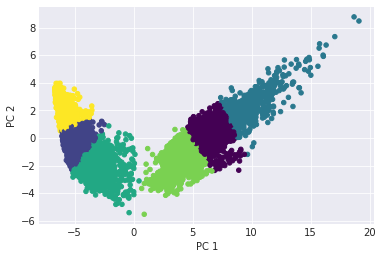

In [129]:
### STUDENT CODE HERE

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred, s=20, cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### STUDENT CODE until HERE

**Question: Describe the clustering result. What can you see from the resulting plot?**

**Answer:** The different classes are seperated more clearly from each other.


##  Evaluation of Clustering results using labels
The labels of the data can be used to evaluate our clustering results. However, it is not possible to calculate the same metrics as used in classification tasks. In classification, the output of a classification algorithm is exactly one of the learned classes. In comparison to that, a clustering algorithm only performs an assignment to one cluster, but we do not know  which class a cluster has found. 

### Cross-Tabulation
Look at the correspondence between the cluster marks and the original class labels. Therefore, calculate a cross-tabulation of the cluster labels and the real labels of the data points.



In [130]:
### STUDENT CODE HERE

pd.crosstab(y, labels_pred, rownames=['real labels'], colnames=['cluster labels'])

### STUDENT CODE until HERE

cluster labels,1,2,3,4,5,6
real labels,,,,,,
1,870,0,198,0,654,0
2,442,0,39,0,1063,0
3,690,0,533,0,183,0
4,0,895,0,332,3,547
5,0,1112,0,564,0,230
6,0,529,0,168,12,1235


**Question: What kinds of activities is the `KMeans` algorithm confused at?**

**Answer:** The KMeans algorithm confuses walking, walking upstairs and walking downstairs with each other and standing, sitting and laying.


### Developing a simple separation metric
We see that for each class (i.e., each activity) the data is assigned to various different clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.

Example: if for class "walking downstairs" (with 1406 instances belonging to it), the distribution of clusters is:
 - cluster 1 - 900
 - cluster 3 - 500
 - cluster 6 - 6,
 
then such a share will be 900/1406 $ \approx $ 0.64.
Calculate this value for all classes.


In [90]:
### STUDENT CODE HERE

cross_tab = pd.crosstab(y, labels_pred, rownames=['real labels'], colnames=['cluster labels'])
sep_metric = [cross_tab.loc[i,:].max()/cross_tab.loc[i,:].sum() for i in range(1,7)]
print(sep_metric)

### STUDENT CODE until HERE

[0.5052264808362369, 0.6884715025906736, 0.4907539118065434, 0.5036578503095104, 0.583420776495278, 0.6352880658436214]


**Question: Which activities are separated from the rest better than others based on the simple metric described above?**

**Answer:** Walking upstairs and laying are separated from the rest better than others.


***Question: How would you rate the results in general? Do you have an explanation for the results?***

**Answer:** For the most activities only about half of the samples were assigned to a single cluster which is why I wouldn't rate the results very good. The explanation for this is that the KMeans algorithm searches for distinct groups of datapoints. In the plot of the different classes we can see however that the groups aren't separated from each other but rather overlap with points from other classes. 


------------------------
# Classification with Decision Trees and K-Nearest-Neighbor

You can notice that the task of clustering the given dataset is not very well solved when we try to detect several clusters (> 2). Now, let's solve the classification problem, given that the data is labeled.

For classification, use the nearest neighbor classifier – class `sklearn.neighbors.KNeighborsClassifier`  and the Decision Tree Classifier – class `sklearn.tree.DecisionTreeClassifier`. We studied these algorithms in course three.

## Choosing best hyperparameters for the algorithms using Cross-Validation

Choose the `n_neighbors` hyperparameter for` KNeighborsClassifier` and the pruning parameter `max_depth` using `GridSearchCV`. 

First step: Fit the  `StandardScaler` on the training set (with all original features), but perform only mean centering. Apply scaling to the test set.

In [96]:
### STUDENT CODE HERE

std = StandardScaler(with_std=False)
std.fit(X_train)

X_train_scaled = pd.DataFrame(std.transform(X_train), columns=featureNames)
X_test_scaled = pd.DataFrame(std.transform(X_test), columns=featureNames)

X_test_scaled.head()

### STUDENT CODE until HERE

,"(1, tBodyAcc-mean()-X)","(2, tBodyAcc-mean()-Y)","(3, tBodyAcc-mean()-Z)","(4, tBodyAcc-std()-X)","(5, tBodyAcc-std()-Y)","(6, tBodyAcc-std()-Z)","(7, tBodyAcc-mad()-X)","(8, tBodyAcc-mad()-Y)","(9, tBodyAcc-mad()-Z)","(10, tBodyAcc-max()-X)",...,"(552, fBodyBodyGyroJerkMag-meanFreq())","(553, fBodyBodyGyroJerkMag-skewness())","(554, fBodyBodyGyroJerkMag-kurtosis())","(555, angle(tBodyAccMean,gravity))","(556, angle(tBodyAccJerkMean),gravityMean))","(557, angle(tBodyGyroMean,gravityMean))","(558, angle(tBodyGyroJerkMean,gravityMean))","(559, angle(X,gravityMean))","(560, angle(Y,gravityMean))","(561, angle(Z,gravityMean))"
0,-0.017310,-0.005590,0.094487,-0.332966,-0.409153,-0.062930,-0.321989,-0.398341,-0.068152,-0.425484,...,-0.053648,-0.023361,-0.080680,-0.002221,0.160734,-0.834611,0.277132,-0.230462,0.218208,-0.001464
1,0.011539,0.004532,-0.009941,-0.369976,-0.456520,-0.340204,-0.356287,-0.441494,-0.339673,-0.425484,...,-0.526482,0.185164,0.030350,-0.092179,0.015313,-0.443100,0.926574,-0.208544,0.222750,-0.027383
2,0.000997,-0.008355,-0.009011,-0.388381,-0.458988,-0.357994,-0.363891,-0.443828,-0.357332,-0.470656,...,-0.062402,0.116587,-0.015442,-0.043640,0.200116,0.055377,0.151049,-0.213224,0.221490,-0.022831
3,-0.004190,-0.014918,-0.008379,-0.389304,-0.462330,-0.362337,-0.364762,-0.447564,-0.362747,-0.470006,...,-0.008598,-0.037409,-0.110830,-0.025751,0.152252,0.331408,0.302388,-0.209407,0.225521,-0.020593
4,0.000345,-0.010152,-0.020386,-0.388414,-0.456508,-0.373541,-0.363599,-0.439045,-0.371196,-0.470006,...,-0.247005,-0.227676,-0.221301,-0.010906,-0.042232,0.727989,-0.112564,-0.202698,0.232129,-0.017342


Second Step: 
Specify a list of parameter values for the Decision Tree and KNeighborsClassifier you want to be evaluated. For example:
- Tree: max_depth: None, 5, 10, 15
- KNN: n_neighbors: 3, 5,7,9,11

In [97]:
### STUDENT CODE HERE

tree_params = {'max_depth':[None, 5, 10, 15]}
knn_params = {'n_neighbors':[3,5,7,9,11]}

### STUDENT CODE until HERE

Third step: Now use the GridSearchCV for Decision Tree and K-Nearest Neighbors.
- In `GridSearchCV`, specify `cv` = 3.
- Fix the random state of the Decision Tree Classifier

In [131]:
#Grid Search CV for Tree
### STUDENT CODE HERE

%time

tree_clf = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), tree_params, cv=3, scoring='accuracy')
tree_clf.fit(X_train_scaled,y_train)

### STUDENT CODE until HERE


Wall time: 0 ns


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [None, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [103]:
#Grid Search CV for K-Nearest Neighbors
### STUDENT CODE HERE

from sklearn.neighbors import KNeighborsClassifier

k_clf = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='accuracy',n_jobs= -1)
k_clf.fit(X_train_scaled,y_train)

### STUDENT CODE until HERE

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Last step: Get the best params, classification score and the model itself for both the Decision Tree as well as the knn-Classifier.

In [105]:
### STUDENT CODE HERE

# Decision_tree
print(tree_clf.best_score_)
print(tree_clf.best_params_)
print(tree_clf.best_estimator_)

#Knn
print(k_clf.best_score_)
print(k_clf.best_params_)
print(k_clf.best_estimator_)

### STUDENT CODE until HERE

0.8337867247007617
{'max_depth': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')
0.8932263329706203
{'n_neighbors': 9}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')


**Question:**
Which value of the hyperparameter `n_neighbors` was chosen the best on the basis of cross-validation? What depth of the tree was selected? Which classifier performed better?

**Answer:** For the knn-Classifier nine neighbours were chosen. For the tree-Classifier a depth of 10 was chosen. Over all the knn_classifier achieved a better result than the tree-Classifier.


## Scoring the Test Set
Now use the best parameter set for the two algorithms and train them on the whole training dataset. Predict the labels of the test set with these models and calculate the accuracy of the two models.

In [110]:
### STUDENT CODE HERE

#Accuracy of decision tree classifier

from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
tree_clf.fit(X_train_scaled, y_train)
y_pred_tree = tree_clf.predict(X_test_scaled)

print("Accuracy: ", accuracy_score(y_test, y_pred_tree))

### STUDENT CODE until HERE

Accuracy:  0.8635900916185952


In [115]:
### STUDENT CODE HERE

#Accuracy of knn-Classifier

knn_clf = KNeighborsClassifier(n_neighbors=9)
knn_clf.fit(X_train_scaled, y_train)
y_pred_knn = knn_clf.predict(X_test_scaled)

print("Accuracy: ", accuracy_score(y_test, y_pred_knn))

### STUDENT CODE until HERE

Accuracy:  0.9053274516457415


**Question:**
Which algorithm performs better on the test set? Which algorithm has better generalization abilities? Interpret the results.

**Answer:** The knn-Classifier performs better on the test set than the decision tree Classifier. Therefore it has better generalization abilities.


## Adding PCA to the Classification 
Finally, do the same thing as in the Question before, but add PCA with the typical value of explained variance we discussed before.

- Use `X_train_scaled` and` X_test_scaled`
- Train the PCA as before, on the scaled training set 
- Apply PCA transformation to the test set



In [117]:
### STUDENT CODE HERE

pca= PCA(n_components=0.9, svd_solver='full', random_state=RANDOM_STATE).fit(X_train_scaled)

var_exp = pca.explained_variance_ratio_
#amount of features
print(len(var_exp))

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


### STUDENT CODE until HERE

34


The shape of the train and test data should have the amount of features we observed above.

In [118]:
assert(X_train_pca.shape == (7352, 34))
assert(X_test_pca.shape == (2947, 34))

Choose the hyperparameters via cross-validation on the training set with PCA-transformation. (Just copy your code from above but use the PCA-transformed dataset)

**Question:** Do you notice a speed difference for the training process? What do you observe if you compare the optimal hyperparameters?

**Answer:** The time needed for the training process is shortened. The chosen optimal hyperparameters are the same as bevor.


In [119]:
%time
### STUDENT CODE HERE

tree_pca = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), tree_params, cv=3, scoring='accuracy')
tree_pca.fit(X_train_pca,y_train)

print(tree_pca.best_score_)
print(tree_pca.best_params_)
print(tree_pca.best_estimator_)

### STUDENT CODE until HERE

Wall time: 0 ns
0.801278563656148
{'max_depth': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')


In [121]:
%time

knn_pca = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='accuracy',n_jobs= -1)
knn_pca.fit(X_train_pca,y_train)

print(knn_pca.best_score_)
print(knn_pca.best_params_)
print(knn_pca.best_estimator_)

Wall time: 0 ns
0.875
{'n_neighbors': 9}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')


Now finally evaluate the results on the test set. Use the accuracy metric. 

In [122]:
### STUDENT CODE HERE

#Accuracy of decision tree classifier with PCA

tree_clf = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
tree_clf.fit(X_train_pca, y_train)
y_pred_tree = tree_clf.predict(X_test_pca)

print("Accuracy: ", accuracy_score(y_test, y_pred_tree))

#Accuracy of knn Classifier with PCA

knn_clf = KNeighborsClassifier(n_neighbors=9)
knn_clf.fit(X_train_pca, y_train)
y_pred_knn = knn_clf.predict(X_test_pca)

print("Accuracy: ", accuracy_score(y_test, y_pred_knn))

### STUDENT CODE until HERE

Accuracy:  0.830335934848999
Accuracy:  0.8815744825246012


**Question:**
What do you observe? What is the difference between the best quality (accuracy) for the test set in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent. Do you have an explanation for the different behavior of the two algorithms?

**Answer:** Bevor the accuracy for the decision tree classifier was 86% now it's 83%. For the knn classifier it was 91% without PCA and with PCA it's 88%. This means for both classifiers the results got worse when using PCA. This makes sense since PCA makes the information laying within the data less detailled and with less details the classifiers can't work as preciseley.


**Question:**
Select all the correct statements:
- Principal component analysis in this case allowed to reduce the model training time, while the quality (accuracy) stays nearly the same
- PCA can be used to visualize data, but there are better methods for this task, for example, [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). However, PCA has lower computational complexity 
- PCA builds linear combinations of initial features, and in some applications they might be poorly interpreted by humans 

**Answer:**
- Principal component analysis in this case allowed to reduce the model training time, while the quality (accuracy) stays nearly the same
- PCA can be used to visualize data, but there are better methods for this task, for example, [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). However, PCA has lower computational complexity 